# 개요
커널이 통과합니다.
1. 데이터를 로드하기 위한 사전 처리 단계입니다.
1. 색 공간을 빠르게 시각화합니다.
1. 간단한 CNN을 훈련합니다.
1. 테스트 데이터에 모델을 적용합니다.
1. RLE 테스트 데이터를 생성합니다.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from glob import glob
import os
from skimage.io import imread
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
dsb_data_dir = os.path.join('.', 'input')
stage_label = 'stage1'

In [2]:
dsb_data_dir

'.\\input'

# Read in the labels
train 세트에 대한 RLE 인코딩 출력을 로드합니다.


In [3]:
train_labels = pd.read_csv(os.path.join(dsb_data_dir,'{}_train_labels.csv'.format(stage_label)))
train_labels

ImageId  \
0      00071198d059ba7f5914a526d124d28e6d010c92466da2...   
1      00071198d059ba7f5914a526d124d28e6d010c92466da2...   
2      00071198d059ba7f5914a526d124d28e6d010c92466da2...   
3      00071198d059ba7f5914a526d124d28e6d010c92466da2...   
4      00071198d059ba7f5914a526d124d28e6d010c92466da2...   
...                                                  ...   
29456  ff599c7301daa1f783924ac8cbe3ce7b42878f15a39c2d...   
29457  ff599c7301daa1f783924ac8cbe3ce7b42878f15a39c2d...   
29458  ff599c7301daa1f783924ac8cbe3ce7b42878f15a39c2d...   
29459  ff599c7301daa1f783924ac8cbe3ce7b42878f15a39c2d...   
29460  ff599c7301daa1f783924ac8cbe3ce7b42878f15a39c2d...   

                                           EncodedPixels  
0      6908 1 7161 8 7417 8 7672 9 7928 9 8184 9 8440...  
1      36269 7 36523 11 36778 13 37033 15 37288 17 37...  
2      19919 6 20174 8 20429 10 20685 11 20941 12 211...  
3      18671 6 18926 8 19181 9 19436 10 19691 11 1994...  
4                40158 3 40413 5 40669 5 40925 5 41182 3  
...                                                  ...  
29456  31317 2 31676 5 32035 6 32394 7 32753 8 33112 ...  
29457  110318 4 110675 13 111034 19 111391 23 111750 ...  
29458  24841 1 25201 2 25561 2 25921 3 26281 4 26641 ...  
29459  4061 8 4417 14 4775 21 5134 23 5494 24 5853 26...  
29460  80876 11 81234 15 81590 20 81948 23 82305 27 8...  

[29461 rows x 2 columns]

In [4]:
train_labels['EncodedPixels'] = train_labels['EncodedPixels'].map(lambda ep: [int(x) for x in ep.split(' ')])
train_labels.sample(3)

ImageId  \
3889   1db1cddf28e305c9478519cfac144eee2242183fe59061...   
27568  ed8c31b001a0c23c33402f94a5ee6b0209e0c6419eb52d...   
26168  e23e11414ee645b51081fb202d38b793f0c8ef2940f822...   

                                           EncodedPixels  
3889   [13697, 6, 13952, 8, 14207, 11, 14462, 13, 147...  
27568  [46343, 5, 46598, 7, 46854, 8, 47110, 9, 47367...  
26168  [133529, 3, 134045, 10, 134564, 13, 135082, 16...

# Load in all Images
여기서는 이미지를 로드하고 경로를 처리하여 각 이미지에 대한 적절한 정보를 제공합니다.


In [5]:
all_images = glob(os.path.join(dsb_data_dir, 'stage1_*', '*', '*', '*'))
all_images

['.\\input\\stage1_test\\0114f484a16c152baa2d82fdd43740880a762c93f436c8988ac461c5c9dbe7d5\\images\\0114f484a16c152baa2d82fdd43740880a762c93f436c8988ac461c5c9dbe7d5.png',
 '.\\input\\stage1_test\\0999dab07b11bc85fb8464fc36c947fbd8b5d6ec49817361cb780659ca805eac\\images\\0999dab07b11bc85fb8464fc36c947fbd8b5d6ec49817361cb780659ca805eac.png',
 '.\\input\\stage1_test\\0a849e0eb15faa8a6d7329c3dd66aabe9a294cccb52ed30a90c8ca99092ae732\\images\\0a849e0eb15faa8a6d7329c3dd66aabe9a294cccb52ed30a90c8ca99092ae732.png',
 '.\\input\\stage1_test\\0e132f71c8b4875c3c2dd7a22997468a3e842b46aa9bd47cf7b0e8b7d63f0925\\images\\0e132f71c8b4875c3c2dd7a22997468a3e842b46aa9bd47cf7b0e8b7d63f0925.png',
 '.\\input\\stage1_test\\0ed3555a4bd48046d3b63d8baf03a5aa97e523aa483aaa07459e7afa39fb96c6\\images\\0ed3555a4bd48046d3b63d8baf03a5aa97e523aa483aaa07459e7afa39fb96c6.png',
 '.\\input\\stage1_test\\0f1f896d9ae5a04752d3239c690402c022db4d72c0d2c087d73380896f72c466\\images\\0f1f896d9ae5a04752d3239c690402c022db4d72c0d2c087d73

In [21]:
all_images = glob(os.path.join(dsb_data_dir, 'stage1_*', '*', '*', '*'))
img_df = pd.DataFrame({'path': all_images})
img_id = lambda in_path: in_path.split('\\')[-3]
img_type = lambda in_path: in_path.split('\\')[-2]
img_group = lambda in_path: in_path.split('\\')[-4].split('_')[1]
img_stage = lambda in_path: in_path.split('\\')[-4].split('_')[0]

img_df['ImageId'] = img_df['path'].map(img_id)
img_df['ImageType'] = img_df['path'].map(img_type)
img_df['TrainingSplit'] = img_df['path'].map(img_group)
img_df['Stage'] = img_df['path'].map(img_stage)
img_df.sample(2)

path  \
10271  .\input\stage1_train\53ad09e4348767bece0165884...   
22984  .\input\stage1_train\bf566e75d5cb0196de4139573...   

                                                 ImageId ImageType  \
10271  53ad09e4348767bece0165884bf40c10b72ae18444e3f4...     masks   
22984  bf566e75d5cb0196de4139573f8bbbda0fa38d5048edf7...     masks   

      TrainingSplit   Stage  
10271         train  stage1  
22984         train  stage1

## Create Training Data

Here we make training data and load all the images into the dataframe. We take a simplification here of grouping all the regions together (rather than keeping them distinct).



In [23]:
train_df = img_df.query('TrainingSplit=="train"')
train_df

path  \
65     .\input\stage1_train\00071198d059ba7f5914a526d...   
66     .\input\stage1_train\00071198d059ba7f5914a526d...   
67     .\input\stage1_train\00071198d059ba7f5914a526d...   
68     .\input\stage1_train\00071198d059ba7f5914a526d...   
69     .\input\stage1_train\00071198d059ba7f5914a526d...   
...                                                  ...   
30191  .\input\stage1_train\ff599c7301daa1f783924ac8c...   
30192  .\input\stage1_train\ff599c7301daa1f783924ac8c...   
30193  .\input\stage1_train\ff599c7301daa1f783924ac8c...   
30194  .\input\stage1_train\ff599c7301daa1f783924ac8c...   
30195  .\input\stage1_train\ff599c7301daa1f783924ac8c...   

                                                 ImageId ImageType  \
65     00071198d059ba7f5914a526d124d28e6d010c92466da2...    images   
66     00071198d059ba7f5914a526d124d28e6d010c92466da2...     masks   
67     00071198d059ba7f5914a526d124d28e6d010c92466da2...     masks   
68     00071198d059ba7f5914a526d124d28e6d010c92466da2...     masks   
69     00071198d059ba7f5914a526d124d28e6d010c92466da2...     masks   
...                                                  ...       ...   
30191  ff599c7301daa1f783924ac8cbe3ce7b42878f15a39c2d...     masks   
30192  ff599c7301daa1f783924ac8cbe3ce7b42878f15a39c2d...     masks   
30193  ff599c7301daa1f783924ac8cbe3ce7b42878f15a39c2d...     masks   
30194  ff599c7301daa1f783924ac8cbe3ce7b42878f15a39c2d...     masks   
30195  ff599c7301daa1f783924ac8cbe3ce7b42878f15a39c2d...     masks   

      TrainingSplit   Stage  
65            train  stage1  
66            train  stage1  
67            train  stage1  
68            train  stage1  
69            train  stage1  
...             ...     ...  
30191         train  stage1  
30192         train  stage1  
30193         train  stage1  
30194         train  stage1  
30195         train  stage1  

[30131 rows x 5 columns]

In [26]:
for n_group, n_rows in train_df.groupby(group_cols):
    print(n_rows)

                                                 path  \
65  .\input\stage1_train\00071198d059ba7f5914a526d...   
66  .\input\stage1_train\00071198d059ba7f5914a526d...   
67  .\input\stage1_train\00071198d059ba7f5914a526d...   
68  .\input\stage1_train\00071198d059ba7f5914a526d...   
69  .\input\stage1_train\00071198d059ba7f5914a526d...   
70  .\input\stage1_train\00071198d059ba7f5914a526d...   
71  .\input\stage1_train\00071198d059ba7f5914a526d...   
72  .\input\stage1_train\00071198d059ba7f5914a526d...   
73  .\input\stage1_train\00071198d059ba7f5914a526d...   
74  .\input\stage1_train\00071198d059ba7f5914a526d...   
75  .\input\stage1_train\00071198d059ba7f5914a526d...   
76  .\input\stage1_train\00071198d059ba7f5914a526d...   
77  .\input\stage1_train\00071198d059ba7f5914a526d...   
78  .\input\stage1_train\00071198d059ba7f5914a526d...   
79  .\input\stage1_train\00071198d059ba7f5914a526d...   
80  .\input\stage1_train\00071198d059ba7f5914a526d...   
81  .\input\stage1_train\000711

In [47]:
%%time
train_df = img_df.query('TrainingSplit=="train"')
train_rows = []
group_cols = ['Stage', 'ImageId']
for n_group, n_rows in train_df.groupby(group_cols):
    c_row = {col_name: col_value for col_name, col_value in zip(group_cols, n_group)}
    c_row['masks'] = n_rows.query('ImageType == "masks"')['path'].values.tolist()
    c_row['images'] = n_rows.query('ImageType == "images"')['path'].values.tolist()
    train_rows += [c_row]
train_img_df = pd.DataFrame(train_rows)

IMG_CHANNELS = 3
def read_and_stack(in_img_list):
    return np.sum(np.stack([imread(c_img) for c_img in in_img_list], 0), 0)/255.0 # [.\input\stage1_train\a]를 숫자로 누적시키고 동일한 픽셀위치끼리 더함 
train_img_df['images'] = train_img_df['images'].map(read_and_stack).map(lambda x: x[:,:,:IMG_CHANNELS]) # 채널제거
train_img_df['masks'] = train_img_df['masks'].map(read_and_stack).map(lambda x: x.astype(int))
train_img_df.sample(1)

Wall time: 2min 42s


Stage                                            ImageId  \
35  stage1  0c6507d493bf79b2ba248c5cca3d14df8b67328b89efa5...   

                                                masks  \
35  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   

                                               images  
35  [[[0.054901960784313725, 0.054901960784313725,...

In [40]:
train_df = img_df.query('TrainingSplit=="train"')
train_rows = []
group_cols = ['Stage', 'ImageId']
for n_group, n_rows in train_df.groupby(group_cols):
    c_row = {col_name: col_value for col_name, col_value in zip(group_cols, n_group)}
    c_row['masks'] = n_rows.query('ImageType == "masks"')['path'].values.tolist()
    c_row['images'] = n_rows.query('ImageType == "images"')['path'].values.tolist()
    train_rows += [c_row]
train_img_df = pd.DataFrame(train_rows)
train_img_df

Stage                                            ImageId  \
0    stage1  00071198d059ba7f5914a526d124d28e6d010c92466da2...   
1    stage1  003cee89357d9fe13516167fd67b609a164651b2193458...   
2    stage1  00ae65c1c6631ae6f2be1a449902976e6eb8483bf6b074...   
3    stage1  0121d6759c5adb290c8e828fc882f37dfaf3663ec885c6...   
4    stage1  01d44a26f6680c42ba94c9bc6339228579a95d0e2695b1...   
..      ...                                                ...   
665  stage1  fec226e45f49ab81ab71e0eaa1248ba09b56a328338dce...   
666  stage1  feffce59a1a3eb0a6a05992bb7423c39c7d52865846da3...   
667  stage1  ff3407842ada5bc18be79ae453e5bdaa1b68afc842fc22...   
668  stage1  ff3e512b5fb860e5855d0c05b6cf5a6bcc7792e4be1f0b...   
669  stage1  ff599c7301daa1f783924ac8cbe3ce7b42878f15a39c2d...   

                                                 masks  \
0    [.\input\stage1_train\00071198d059ba7f5914a526...   
1    [.\input\stage1_train\003cee89357d9fe13516167f...   
2    [.\input\stage1_train\00ae65c1c6631ae6f2be1a44...   
3    [.\input\stage1_train\0121d6759c5adb290c8e828f...   
4    [.\input\stage1_train\01d44a26f6680c42ba94c9bc...   
..                                                 ...   
665  [.\input\stage1_train\fec226e45f49ab81ab71e0ea...   
666  [.\input\stage1_train\feffce59a1a3eb0a6a05992b...   
667  [.\input\stage1_train\ff3407842ada5bc18be79ae4...   
668  [.\input\stage1_train\ff3e512b5fb860e5855d0c05...   
669  [.\input\stage1_train\ff599c7301daa1f783924ac8...   

                                                images  
0    [.\input\stage1_train\00071198d059ba7f5914a526...  
1    [.\input\stage1_train\003cee89357d9fe13516167f...  
2    [.\input\stage1_train\00ae65c1c6631ae6f2be1a44...  
3    [.\input\stage1_train\0121d6759c5adb290c8e828f...  
4    [.\input\stage1_train\01d44a26f6680c42ba94c9bc...  
..                                                 ...  
665  [.\input\stage1_train\fec226e45f49ab81ab71e0ea...  
666  [.\input\stage1_train\feffce59a1a3eb0a6a05992b...  
667  [.\input\stage1_train\ff3407842ada5bc18be79ae4...  
668  [.\input\stage1_train\ff3e512b5fb860e5855d0c05...  
669  [.\input\stage1_train\ff599c7301daa1f783924ac8...  

[670 rows x 4 columns]

In [46]:
train_df = img_df.query('TrainingSplit=="train"')
train_rows = []
group_cols = ['Stage', 'ImageId']
for n_group, n_rows in train_df.groupby(group_cols):
    c_row = {col_name: col_value for col_name, col_value in zip(group_cols, n_group)}
    c_row['masks'] = n_rows.query('ImageType == "masks"')['path'].values.tolist()
    c_row['images'] = n_rows.query('ImageType == "images"')['path'].values.tolist()
    train_rows += [c_row]
train_img_df = pd.DataFrame(train_rows)

IMG_CHANNELS = 3
def read_and_stack(in_img_list):
    return np.sum(np.stack([imread(c_img) for c_img in in_img_list], 0), 0)/255.0
train_img_df['images'] = train_img_df['images'].map(read_and_stack)
train_img_df['images'][0]

array([[[0.01960784, 0.01960784, 0.01960784, 1.        ],
        [0.01960784, 0.01960784, 0.01960784, 1.        ],
        [0.01960784, 0.01960784, 0.01960784, 1.        ],
        ...,
        [0.01568627, 0.01568627, 0.01568627, 1.        ],
        [0.01176471, 0.01176471, 0.01176471, 1.        ],
        [0.01176471, 0.01176471, 0.01176471, 1.        ]],

       [[0.02352941, 0.02352941, 0.02352941, 1.        ],
        [0.01960784, 0.01960784, 0.01960784, 1.        ],
        [0.01960784, 0.01960784, 0.01960784, 1.        ],
        ...,
        [0.01568627, 0.01568627, 0.01568627, 1.        ],
        [0.01568627, 0.01568627, 0.01568627, 1.        ],
        [0.01176471, 0.01176471, 0.01176471, 1.        ]],

       [[0.02352941, 0.02352941, 0.02352941, 1.        ],
        [0.01960784, 0.01960784, 0.01960784, 1.        ],
        [0.01960784, 0.01960784, 0.01960784, 1.        ],
        ...,
        [0.01960784, 0.01960784, 0.01960784, 1.        ],
        [0.01568627, 0.015686

In [44]:
train_df = img_df.query('TrainingSplit=="train"')
train_rows = []
group_cols = ['Stage', 'ImageId']
for n_group, n_rows in train_df.groupby(group_cols):
    c_row = {col_name: col_value for col_name, col_value in zip(group_cols, n_group)}
    c_row['masks'] = n_rows.query('ImageType == "masks"')['path'].values.tolist()
    c_row['images'] = n_rows.query('ImageType == "images"')['path'].values.tolist()
    train_rows += [c_row]
train_img_df = pd.DataFrame(train_rows)

IMG_CHANNELS = 3
def read_and_stack(in_img_list):
    return np.sum(np.stack([imread(c_img) for c_img in in_img_list], 0), 0)/255.0
train_img_df['images'] = train_img_df['images'].map(read_and_stack).map(lambda x: x[:,:,:IMG_CHANNELS])
train_img_df['images'][0] # (256, 256, 3)

array([[[0.01960784, 0.01960784, 0.01960784],
        [0.01960784, 0.01960784, 0.01960784],
        [0.01960784, 0.01960784, 0.01960784],
        ...,
        [0.01568627, 0.01568627, 0.01568627],
        [0.01176471, 0.01176471, 0.01176471],
        [0.01176471, 0.01176471, 0.01176471]],

       [[0.02352941, 0.02352941, 0.02352941],
        [0.01960784, 0.01960784, 0.01960784],
        [0.01960784, 0.01960784, 0.01960784],
        ...,
        [0.01568627, 0.01568627, 0.01568627],
        [0.01568627, 0.01568627, 0.01568627],
        [0.01176471, 0.01176471, 0.01176471]],

       [[0.02352941, 0.02352941, 0.02352941],
        [0.01960784, 0.01960784, 0.01960784],
        [0.01960784, 0.01960784, 0.01960784],
        ...,
        [0.01960784, 0.01960784, 0.01960784],
        [0.01568627, 0.01568627, 0.01568627],
        [0.01176471, 0.01176471, 0.01176471]],

       ...,

       [[0.01176471, 0.01176471, 0.01176471],
        [0.01176471, 0.01176471, 0.01176471],
        [0.01176471, 0

# Show a few images
    
여기에서 단일 분할 알고리즘을 사용하기 어렵게 만드는 밝은 시야와 형광이 혼합되어 있는 세포의 몇 가지 이미지를 보여줍니다.


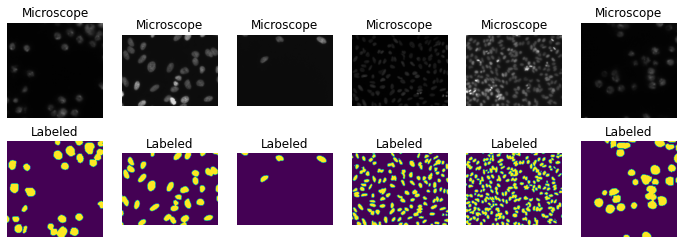

In [48]:
n_img = 6
fig, m_axs = plt.subplots(2, n_img, figsize = (12, 4))
for (_, c_row), (c_im, c_lab) in zip(train_img_df.sample(n_img).iterrows(), 
                                     m_axs.T):
    c_im.imshow(c_row['images'])
    c_im.axis('off')
    c_im.set_title('Microscope')
    
    c_lab.imshow(c_row['masks'])
    c_lab.axis('off')
    c_lab.set_title('Labeled')

# Look at the intensity distribution
여기서 우리는 강도 분포를 간략하게 살펴보고 몇 개의 그룹이 형성되는 것을 볼 수 있습니다. 아마도 별도로 처리되어야 합니다.


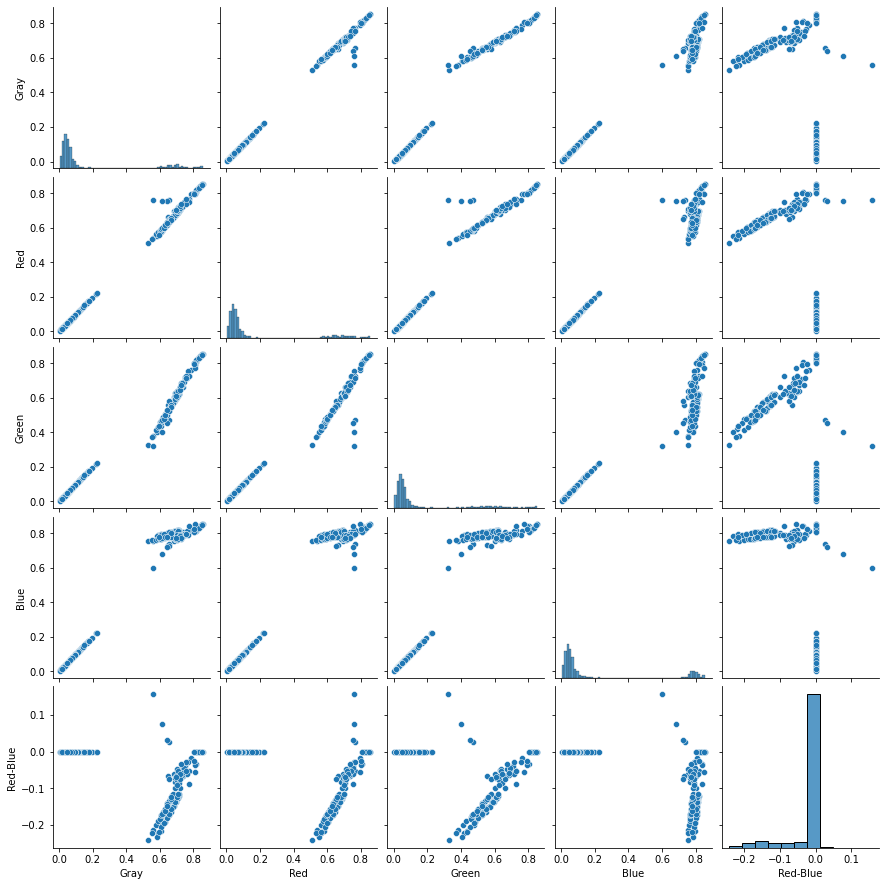

In [49]:
train_img_df['Red'] = train_img_df['images'].map(lambda x: np.mean(x[:,:,0]))
train_img_df['Green'] = train_img_df['images'].map(lambda x: np.mean(x[:,:,1]))
train_img_df['Blue'] = train_img_df['images'].map(lambda x: np.mean(x[:,:,2]))
train_img_df['Gray'] = train_img_df['images'].map(lambda x: np.mean(x))
train_img_df['Red-Blue'] = train_img_df['images'].map(lambda x: np.mean(x[:,:,0]-x[:,:,2]))
sns.pairplot(train_img_df[['Gray', 'Red', 'Green', 'Blue', 'Red-Blue']])

# Check Dimensions 
여기에서 입력 이미지의 다양성을 보기 위해 데이터의 차원을 보여줍니다.


In [50]:
train_img_df['images'].map(lambda x: x.shape).value_counts()

(256, 256, 3)      334
(256, 320, 3)      112
(520, 696, 3)       92
(360, 360, 3)       91
(1024, 1024, 3)     16
(512, 640, 3)       13
(603, 1272, 3)       6
(260, 347, 3)        5
(1040, 1388, 3)      1
Name: images, dtype: int64

In [75]:
train_img_df=train_img_df[train_img_df['images'].map(lambda x: x.shape)==(256,256,3)]

## Making a simple CNN
여기에서 우리는 그것이 얼마나 잘 작동하는지에 대한 빠른 아이디어를 얻기 위해 매우 간단한 CNN을 만듭니다. 이를 위해 배치 정규화를 사용하여 입력을 정규화합니다. 문제를 단순하게 유지하기 위해 패딩으로 약간의 속임수를 사용합니다.


In [51]:
from keras.models import Sequential
from keras.layers import BatchNormalization, Conv2D, UpSampling2D, Lambda
simple_cnn = Sequential()
simple_cnn.add(BatchNormalization(input_shape = (None, None, IMG_CHANNELS), 
                                  name = 'NormalizeInput'))
simple_cnn.add(Conv2D(8, kernel_size = (3,3), padding = 'same'))
simple_cnn.add(Conv2D(8, kernel_size = (3,3), padding = 'same'))
# 확장= dilation_rate을 사용하여 시야를 조금 더 넓힙니다. 
simple_cnn.add(Conv2D(16, kernel_size = (3,3), dilation_rate = 2, padding = 'same'))
simple_cnn.add(Conv2D(16, kernel_size = (3,3), dilation_rate = 2, padding = 'same'))
simple_cnn.add(Conv2D(32, kernel_size = (3,3), dilation_rate = 3, padding = 'same'))

# the final processing
simple_cnn.add(Conv2D(16, kernel_size = (1,1), padding = 'same'))
simple_cnn.add(Conv2D(1, kernel_size = (1,1), padding = 'same', activation = 'sigmoid'))
simple_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 NormalizeInput (BatchNormal  (None, None, None, 3)    12        
 ization)                                                        
                                                                 
 conv2d (Conv2D)             (None, None, None, 8)     224       
                                                                 
 conv2d_1 (Conv2D)           (None, None, None, 8)     584       
                                                                 
 conv2d_2 (Conv2D)           (None, None, None, 16)    1168      
                                                                 
 conv2d_3 (Conv2D)           (None, None, None, 16)    2320      
                                                                 
 conv2d_4 (Conv2D)           (None, None, None, 32)    4640      
                                                        

# Loss
합집합에 대한 교집합으로 평가되기 때문에 DICE 점수의 역함수를 손실 함수로 사용하여 최적화할 수 있습니다.


In [66]:
a=np.array([1, 2])
b=np.array([3, 4])
sum(a*b) # 3+8

11

In [52]:
from keras import backend as K
smooth = 1.
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    # (2. * K.sum(y_true_f * y_pred_f) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

simple_cnn.compile(optimizer = 'adam', 
                   loss = dice_coef_loss, 
                   metrics = [dice_coef, 'acc', 'mse'])

# Simple Training
여기에서 각 이미지가 자체 배치인 간단한 교육을 실행하지만(좋은 생각은 아님) 코드를 단순하게 유지합니다.


In [60]:
for _, c_row in train_img_df.iterrows():
    print(c_row)

Stage                                                  stage1
ImageId     00071198d059ba7f5914a526d124d28e6d010c92466da2...
masks       [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
images      [[[0.0196078431372549, 0.0196078431372549, 0.0...
Red                                                  0.024087
Green                                                0.024087
Blue                                                 0.024087
Gray                                                 0.024087
Red-Blue                                                  0.0
Name: 0, dtype: object
Stage                                                  stage1
ImageId     003cee89357d9fe13516167fd67b609a164651b2193458...
masks       [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
images      [[[0.0196078431372549, 0.0196078431372549, 0.0...
Red                                                  0.035367
Green                                                0.035367
Blue                                           

KeyboardInterrupt: 

In [76]:
def simple_gen():
    while True:
        for _, c_row in train_img_df.iterrows(): # _는 인덱스 자리, c_row는 df형태의 series
            yield np.expand_dims(c_row['images'],0), np.expand_dims(np.expand_dims(c_row['masks'],-1),0).astype('float32')
            # (1,n,m,3), (1,n,m,1)형태

simple_cnn.fit(simple_gen(), 
                         steps_per_epoch=train_img_df.shape[0],
                        epochs = 3)

Epoch 1/3


TypeError: 'NoneType' object is not callable

In [68]:
for _, c_row in train_img_df.iterrows():
    print(np.expand_dims(c_row['images'],0), np.expand_dims(np.expand_dims(c_row['masks'],-1),0).astype('float32')) 


[[[[0.01960784 0.01960784 0.01960784]
   [0.01960784 0.01960784 0.01960784]
   [0.01960784 0.01960784 0.01960784]
   ...
   [0.01568627 0.01568627 0.01568627]
   [0.01176471 0.01176471 0.01176471]
   [0.01176471 0.01176471 0.01176471]]

  [[0.02352941 0.02352941 0.02352941]
   [0.01960784 0.01960784 0.01960784]
   [0.01960784 0.01960784 0.01960784]
   ...
   [0.01568627 0.01568627 0.01568627]
   [0.01568627 0.01568627 0.01568627]
   [0.01176471 0.01176471 0.01176471]]

  [[0.02352941 0.02352941 0.02352941]
   [0.01960784 0.01960784 0.01960784]
   [0.01960784 0.01960784 0.01960784]
   ...
   [0.01960784 0.01960784 0.01960784]
   [0.01568627 0.01568627 0.01568627]
   [0.01176471 0.01176471 0.01176471]]

  ...

  [[0.01176471 0.01176471 0.01176471]
   [0.01176471 0.01176471 0.01176471]
   [0.01176471 0.01176471 0.01176471]
   ...
   [0.00784314 0.00784314 0.00784314]
   [0.00784314 0.00784314 0.00784314]
   [0.01176471 0.01176471 0.01176471]]

  [[0.01176471 0.01176471 0.01176471]
   [0.0

In [77]:
a = np.array([1.1])
a = a.astype('int')
a

array([1])

In [71]:
for _, c_row in train_img_df.iterrows():
    print(np.expand_dims(c_row['images'],0).shape, np.expand_dims(np.expand_dims(c_row['masks'],-1),0).astype('float32').shape) 
    

(1, 256, 256, 3) (1, 256, 256, 1)
(1, 256, 256, 3) (1, 256, 256, 1)
(1, 256, 320, 3) (1, 256, 320, 1)
(1, 256, 320, 3) (1, 256, 320, 1)
(1, 256, 320, 3) (1, 256, 320, 1)
(1, 256, 256, 3) (1, 256, 256, 1)
(1, 256, 256, 3) (1, 256, 256, 1)
(1, 360, 360, 3) (1, 360, 360, 1)
(1, 256, 256, 3) (1, 256, 256, 1)
(1, 360, 360, 3) (1, 360, 360, 1)
(1, 360, 360, 3) (1, 360, 360, 1)
(1, 260, 347, 3) (1, 260, 347, 1)
(1, 256, 256, 3) (1, 256, 256, 1)
(1, 256, 256, 3) (1, 256, 256, 1)
(1, 360, 360, 3) (1, 360, 360, 1)
(1, 256, 256, 3) (1, 256, 256, 1)
(1, 256, 256, 3) (1, 256, 256, 1)
(1, 360, 360, 3) (1, 360, 360, 1)
(1, 256, 256, 3) (1, 256, 256, 1)
(1, 256, 256, 3) (1, 256, 256, 1)
(1, 256, 256, 3) (1, 256, 256, 1)
(1, 520, 696, 3) (1, 520, 696, 1)
(1, 360, 360, 3) (1, 360, 360, 1)
(1, 1024, 1024, 3) (1, 1024, 1024, 1)
(1, 256, 256, 3) (1, 256, 256, 1)
(1, 1024, 1024, 3) (1, 1024, 1024, 1)
(1, 256, 256, 3) (1, 256, 256, 1)
(1, 256, 256, 3) (1, 256, 256, 1)
(1, 256, 256, 3) (1, 256, 256, 1)
(1, 52

In [57]:
for _, c_row in train_img_df.iterrows():
    print(np.expand_dims(c_row['images'],0)) 


[[[[0.01960784 0.01960784 0.01960784]
   [0.01960784 0.01960784 0.01960784]
   [0.01960784 0.01960784 0.01960784]
   ...
   [0.01568627 0.01568627 0.01568627]
   [0.01176471 0.01176471 0.01176471]
   [0.01176471 0.01176471 0.01176471]]

  [[0.02352941 0.02352941 0.02352941]
   [0.01960784 0.01960784 0.01960784]
   [0.01960784 0.01960784 0.01960784]
   ...
   [0.01568627 0.01568627 0.01568627]
   [0.01568627 0.01568627 0.01568627]
   [0.01176471 0.01176471 0.01176471]]

  [[0.02352941 0.02352941 0.02352941]
   [0.01960784 0.01960784 0.01960784]
   [0.01960784 0.01960784 0.01960784]
   ...
   [0.01960784 0.01960784 0.01960784]
   [0.01568627 0.01568627 0.01568627]
   [0.01176471 0.01176471 0.01176471]]

  ...

  [[0.01176471 0.01176471 0.01176471]
   [0.01176471 0.01176471 0.01176471]
   [0.01176471 0.01176471 0.01176471]
   ...
   [0.00784314 0.00784314 0.00784314]
   [0.00784314 0.00784314 0.00784314]
   [0.01176471 0.01176471 0.01176471]]

  [[0.01176471 0.01176471 0.01176471]
   [0.0

In [58]:
for _, c_row in train_img_df.iterrows():
    print(c_row['images']) 


[[[0.01960784 0.01960784 0.01960784]
  [0.01960784 0.01960784 0.01960784]
  [0.01960784 0.01960784 0.01960784]
  ...
  [0.01568627 0.01568627 0.01568627]
  [0.01176471 0.01176471 0.01176471]
  [0.01176471 0.01176471 0.01176471]]

 [[0.02352941 0.02352941 0.02352941]
  [0.01960784 0.01960784 0.01960784]
  [0.01960784 0.01960784 0.01960784]
  ...
  [0.01568627 0.01568627 0.01568627]
  [0.01568627 0.01568627 0.01568627]
  [0.01176471 0.01176471 0.01176471]]

 [[0.02352941 0.02352941 0.02352941]
  [0.01960784 0.01960784 0.01960784]
  [0.01960784 0.01960784 0.01960784]
  ...
  [0.01960784 0.01960784 0.01960784]
  [0.01568627 0.01568627 0.01568627]
  [0.01176471 0.01176471 0.01176471]]

 ...

 [[0.01176471 0.01176471 0.01176471]
  [0.01176471 0.01176471 0.01176471]
  [0.01176471 0.01176471 0.01176471]
  ...
  [0.00784314 0.00784314 0.00784314]
  [0.00784314 0.00784314 0.00784314]
  [0.01176471 0.01176471 0.01176471]]

 [[0.01176471 0.01176471 0.01176471]
  [0.01176471 0.01176471 0.01176471]


# Apply Model to Test
Here we apply the model to the test data

In [11]:
%%time
test_df = img_df.query('TrainingSplit=="test"')
test_rows = []
group_cols = ['Stage', 'ImageId']
for n_group, n_rows in test_df.groupby(group_cols):
    c_row = {col_name: col_value for col_name, col_value in zip(group_cols, n_group)}
    c_row['images'] = n_rows.query('ImageType == "images"')['path'].values.tolist()
    test_rows += [c_row]
test_img_df = pd.DataFrame(test_rows)    

test_img_df['images'] = test_img_df['images'].map(read_and_stack).map(lambda x: x[:,:,:IMG_CHANNELS])
print(test_img_df.shape[0], 'images to process')
test_img_df.sample(1)

65 images to process
CPU times: user 956 ms, sys: 12 ms, total: 968 ms
Wall time: 963 ms


In [12]:
%%time
test_img_df['masks'] = test_img_df['images'].map(lambda x: simple_cnn.predict(np.expand_dims(x, 0))[0, :, :, 0])

CPU times: user 32.5 s, sys: 33.9 s, total: 1min 6s
Wall time: 17.4 s


## Show a few predictions

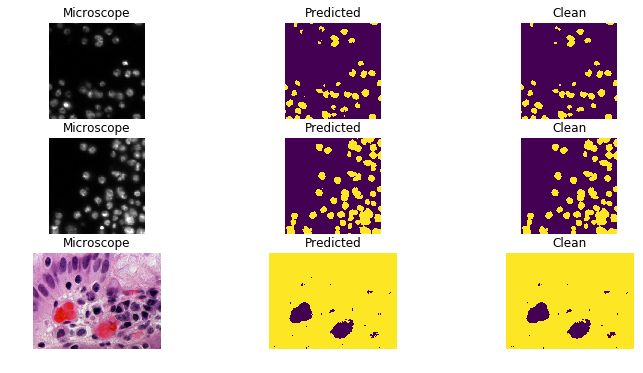

In [13]:
n_img = 3
from skimage.morphology import closing, opening, disk
def clean_img(x):
    return opening(closing(x, disk(1)), disk(3))
fig, m_axs = plt.subplots(3, n_img, figsize = (12, 6))
for (_, d_row), (c_im, c_lab, c_clean) in zip(test_img_df.sample(n_img).iterrows(), 
                                     m_axs):
    c_im.imshow(d_row['images'])
    c_im.axis('off')
    c_im.set_title('Microscope')
    
    c_lab.imshow(d_row['masks'])
    c_lab.axis('off')
    c_lab.set_title('Predicted')
    
    c_clean.imshow(clean_img(d_row['masks']))
    c_clean.axis('off')
    c_clean.set_title('Clean')

# Check RLE
Check that our approach for RLE encoding (stolen from [here](https://www.kaggle.com/rakhlin/fast-run-length-encoding-python)) works

In [14]:
from skimage.morphology import label # label regions
def rle_encoding(x):
    '''
    x: numpy array of shape (height, width), 1 - mask, 0 - background
    Returns run length as list
    '''
    dots = np.where(x.T.flatten()==1)[0] # .T sets Fortran order down-then-right
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b+1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cut_off = 0.5):
    lab_img = label(x>cut_off)
    if lab_img.max()<1:
        lab_img[0,0] = 1 # ensure at least one prediction per image
    for i in range(1, lab_img.max()+1):
        yield rle_encoding(lab_img==i)

## Calculate the RLEs for a Train Image

In [15]:
_, train_rle_row = next(train_img_df.tail(5).iterrows()) 
train_row_rles = list(prob_to_rles(train_rle_row['masks']))

## Take the RLEs from the CSV

In [16]:
tl_rles = train_labels.query('ImageId=="{ImageId}"'.format(**train_rle_row))['EncodedPixels']

## Check
Since we made some simplifications, we don't expect everything to be perfect, but pretty close

In [17]:
match, mismatch = 0, 0
for img_rle, train_rle in zip(sorted(train_row_rles, key = lambda x: x[0]), 
                             sorted(tl_rles, key = lambda x: x[0])):
    for i_x, i_y in zip(img_rle, train_rle):
        if i_x == i_y:
            match += 1
        else:
            mismatch += 1
print('Matches: %d, Mismatches: %d, Accuracy: %2.1f%%' % (match, mismatch, 100.0*match/(match+mismatch)))

Matches: 360, Mismatches: 0, Accuracy: 100.0%


# Calculate RLE for all the masks
Here we generate the RLE for all the masks and output the the results to a table. We use a few morphological operations to clean up the images before submission since they can be very messy (remove single pixels, connect nearby regions, etc)

In [18]:
test_img_df['rles'] = test_img_df['masks'].map(clean_img).map(lambda x: list(prob_to_rles(x)))

In [19]:
out_pred_list = []
for _, c_row in test_img_df.iterrows():
    for c_rle in c_row['rles']:
        out_pred_list+=[dict(ImageId=c_row['ImageId'], 
                             EncodedPixels = ' '.join(np.array(c_rle).astype(str)))]
out_pred_df = pd.DataFrame(out_pred_list)
print(out_pred_df.shape[0], 'regions found for', test_img_df.shape[0], 'images')
out_pred_df.sample(3)

1554 regions found for 65 images


EncodedPixels  \
752   51404 2 51662 6 51919 11 52177 14 52436 16 526...   
1097  331814 1 331833 2 332332 6 332351 6 332852 8 3...   
801   45373 3 45891 7 46410 9 46930 11 47449 13 4796...   

                                                ImageId  
752   699f2992cd71e2e28cf45f81347ff22e76b37541ce8808...  
1097  ade080c6618cbbb0a25680cf847f312b5e19b22bfe1caf...  
801   78a981bd27ba0c65a9169548665a17bda9f49050d0d389...

In [20]:
out_pred_df[['ImageId', 'EncodedPixels']].to_csv('predictions.csv', index = False)